<a href="https://colab.research.google.com/github/tesnimaltindal/Plant_Diseases_Detection/blob/main/plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Mount Google Drive and Set Up Paths

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your dataset in Google Drive.
# IMPORTANT: Adjust this path according to where you placed the 'Plant Diseases' folder in your Drive.
# Based on your screenshot, it looks like you have 'Test', 'Train', 'Validation' directly inside a folder.
# Let's assume you uploaded these three folders directly into a folder named 'Plant Diseases' in your Drive.
dataset_base_path = '/content/drive/MyDrive/Plant Diseases' # <--- MAKE SURE THIS PATH IS CORRECT!

# Define paths for training, validation, and test directories
train_dir = os.path.join(dataset_base_path, 'Train')
validation_dir = os.path.join(dataset_base_path, 'Validation') # Note: The dataset uses 'Validation'
test_dir = os.path.join(dataset_base_path, 'Test')

# Verify that the directories exist (optional but good practice)
print(f"Train directory exists? {os.path.exists(train_dir)}")
print(f"Validation directory exists? {os.path.exists(validation_dir)}")
print(f"Test directory exists? {os.path.exists(test_dir)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train directory exists? True
Validation directory exists? True
Test directory exists? True


2. Data Preparation and Augmentation

In [ ]:
# Image parameters
image_size = (128, 128) # Resize images to 128x128 for faster training
batch_size = 32

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20, # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2, # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2, # Apply shear transformations
    zoom_range=0.2, # Randomly zoom into images
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest' # Fill new pixels created by transformations
)

# Only rescale for validation and test data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical' # Use 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Do not shuffle validation data for consistent evaluation
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Do not shuffle test data
)

# Get the class names (useful for prediction later)
class_names = list(train_generator.class_indices.keys())
print(f"\nNumber of classes detected: {len(class_names)}")
print(f"Class names: {class_names}")

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 149 images belonging to 3 classes.

Number of classes detected: 3
Class names: ['Healthy', 'Powdery', 'Rust']


3. Build the CNN Model

In [ ]:
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the 3D output to 1D
    Flatten(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout for regularization (to prevent overfitting)

    # Output Layer
    Dense(len(class_names), activation='softmax') # Number of units equals number of classes
])

# Compile the model
model.compile(optimizer='adam', # Adam optimizer is a good default
              loss='categorical_crossentropy', # Appropriate loss for multi-class classification
              metrics=['accuracy']) # Monitor accuracy during training

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

4. Train the Model

In [ ]:
# Set the number of epochs
epochs = 10 # Adjust as needed, lower for faster training

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3607 - loss: 1.1242 - val_accuracy: 0.8750 - val_loss: 0.5993
Epoch 2/10
 1/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6875 - loss: 0.7149

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6875 - loss: 0.7149 - val_accuracy: 0.8438 - val_loss: 0.5728
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6500 - loss: 0.7961 - val_accuracy: 0.8750 - val_loss: 0.5426
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7812 - loss: 0.6444 - val_accuracy: 0.8125 - val_loss: 0.6343
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8388 - loss: 0.4682 - val_accuracy: 0.8750 - val_loss: 0.2726
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8438 - loss: 0.4707 - val_accuracy: 0.8750 - val_loss: 0.2663
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8521 - loss: 0.4425 - val_accuracy: 0.9062 - val_loss: 0.2815
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.8750 - loss: 0.3326 - val_accuracy: 0.8750 - val_loss: 0.2658
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8645 - loss: 0.3836 - val_accuracy: 0.8750 - val_loss:

5. Evaluate the Model

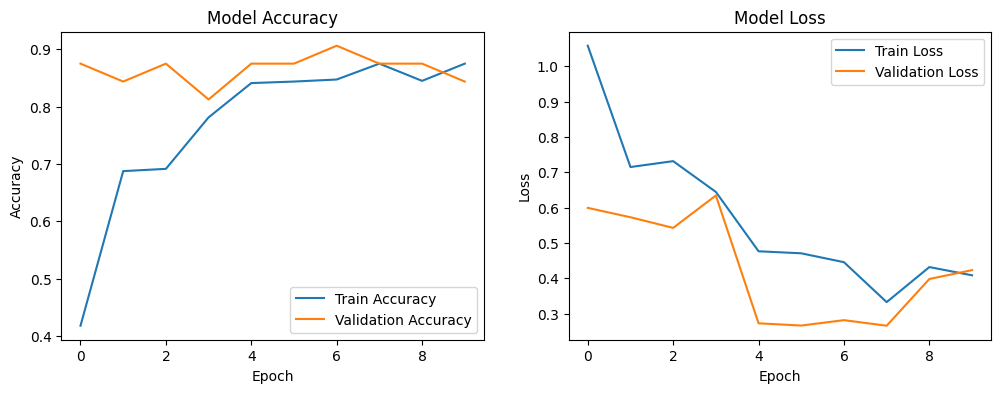


Evaluating model on the test dataset:
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9057 - loss: 0.4178
Test Accuracy: 89.93%
Test Loss: 0.3723


In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the unseen test data
print("\nEvaluating model on the test dataset:")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

6. Make Predictions on a Single Image (Optional but Recommended)

In [ ]:
def predict_image(image_path_for_prediction):
    print(f"Attempting to load image from: {content/drive/MyDrive/PlantDiseases/Test/Healthy/test.JPG}")
    try:
        img = tf.keras.preprocessing.image.load_img(image_path_for_prediction, target_size=image_size)
        print("Image loaded successfully.")
    except Exception as e:
        print(f"Error loading image: {e}")
        return # Hata varsa buradan çık

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    print("Making prediction...")
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(predictions[0]) * 100

    print(f"Prediction made: {predicted_class_name} with {confidence:.2f}% confidence.")
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class_name}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

In [ ]:
def classify_plant_disease(input_image):
    if input_image is None:
        return "Please upload a Leaf Image", {}

    # Debugging prints
    print(f"Input image shape: {input_image.shape}")
    print(f"Target image size: {image_size}")

    try:
        img_resized = tf.image.resize(input_image, image_size)
        print(f"Resized image shape: {img_resized.shape}")
    except Exception as e:
        print(f"Error during image resize: {e}")
        return "Image Resize Error", {} # Hata mesajını Gradio'ya döndür

    img_array = np.expand_dims(img_resized, axis=0)
    img_array /= 255.0

    print("Making prediction...")
    try:
        predictions = model.predict(img_array)[0]
        print(f"Predictions: {predictions}")
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return "Model Prediction Error", {} # Hata mesajını Gradio'ya döndür

    confidences = {class_names[i]: float(predictions[i]) for i in range(len(class_names))}

    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]
    predicted_confidence = np.max(predictions) * 100

    return predicted_class_name, confidences